In [1]:
import torch
import numpy as np
from training import train
from data_utils import make_dataset, load_dataset, fit_dset_to_m, make_grid_dataset
from controls import LQR
from tasks import stabilize_cartpole
from plotting import plot_trajectories, plot_experiment_new
from models import save_model, load_model
from experiments import run_experiment, save_experiment, load_experiment
import params
from IPython.display import HTML
from copy import deepcopy
import matplotlib.pyplot as plt
import seaborn as sns

######################
### DISPLAY CONFIG ###
######################
for name, values in vars(params).items():
    print(name, values)

torch.set_default_device("cuda")
#torch.set_default_device("cpu")

%load_ext autoreload
%autoreload 2

/home1/lutkus/.conda/envs/latent-space/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


__name__ params
__doc__ None
__package__ 
__loader__ <_frozen_importlib_external.SourceFileLoader object at 0x7f2a0bc2ed50>
__spec__ ModuleSpec(name='params', loader=<_frozen_importlib_external.SourceFileLoader object at 0x7f2a0bc2ed50>, origin='/home1/lutkus/latent_space/cartpole_lyapunov/params.py')
__file__ /home1/lutkus/latent_space/cartpole_lyapunov/params.py
__cached__ /home1/lutkus/latent_space/cartpole_lyapunov/__pycache__/params.cpython-313.pyc
__builtins__ {'__name__': 'builtins', '__doc__': "Built-in functions, types, exceptions, and other objects.\n\nThis module provides direct access to all 'built-in'\nidentifiers of Python; for example, builtins.len is\nthe full name for the built-in function len().\n\nThis module is not normally accessed explicitly by most\napplications, but can be useful in modules that provide\nobjects with the same name as a built-in value, but in\nwhich the built-in of that name is also needed.", '__package__': '', '__loader__': <class '_frozen_impor

In [2]:
#data = make_dataset(save=True, fname=params.dataset, render_mode=None, expert_controller=False)
#data = make_grid_dataset([0.5, 0.5, 0.5, 0.5], [3], 10)
#data = make_grid_dataset(params.grid_x_ranges, params.grid_u_ranges, params.grid_n_per_axis)
data = load_dataset(fname=params.dataset)
X, U, Xtest, Utest = data
'''
data_rand = load_dataset(fname=params.dataset2)
X0, U0 = fit_dset_to_m(X[0], U[0])
X = (torch.vstack([X0,data_rand[0][0]]), torch.vstack([X[1],data_rand[0][1]]))
U = (torch.vstack([U0,data_rand[1][0]]), None)
Xtest0, Utest0 = fit_dset_to_m(Xtest[0], Utest[0])
Xtest = (torch.vstack([Xtest0,data_rand[2][0]]), torch.vstack([Xtest[1],data_rand[2][1]]))
Utest = (torch.vstack([Utest0,data_rand[3][0]]), None)
print("DSET SIZES:")
print(X[0].shape)
print(X[1].shape)
'''

/home1/lutkus/.conda/envs/latent-space/lib/python3.13/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


'\ndata_rand = load_dataset(fname=params.dataset2)\nX0, U0 = fit_dset_to_m(X[0], U[0])\nX = (torch.vstack([X0,data_rand[0][0]]), torch.vstack([X[1],data_rand[0][1]]))\nU = (torch.vstack([U0,data_rand[1][0]]), None)\nXtest0, Utest0 = fit_dset_to_m(Xtest[0], Utest[0])\nXtest = (torch.vstack([Xtest0,data_rand[2][0]]), torch.vstack([Xtest[1],data_rand[2][1]]))\nUtest = (torch.vstack([Utest0,data_rand[3][0]]), None)\nprint("DSET SIZES:")\nprint(X[0].shape)\nprint(X[1].shape)\n'

15
original state:
 [(0, 1, 3), (2,)]
n_combinations 4
n_params 2
{'ae': [('symbols=(0, 1, 2, 3)\nignored=()', []), ('symbols=(0, 1, 3)\nignored=(2,)', []), ('symbols=(1, 2, 3)\nignored=(0,)', []), ('symbols=(1, 3)\nignored=(0, 2)', [])], 'fdyn': [('symbols=(0, 1, 2, 3)\nignored=()', []), ('symbols=(0, 1, 3)\nignored=(2,)', []), ('symbols=(1, 2, 3)\nignored=(0,)', []), ('symbols=(1, 3)\nignored=(0, 2)', [])], 'ae_opt': [('symbols=(0, 1, 2, 3)\nignored=()', []), ('symbols=(0, 1, 3)\nignored=(2,)', []), ('symbols=(1, 2, 3)\nignored=(0,)', []), ('symbols=(1, 3)\nignored=(0, 2)', [])], 'fdyn_opt': [('symbols=(0, 1, 2, 3)\nignored=()', []), ('symbols=(0, 1, 3)\nignored=(2,)', []), ('symbols=(1, 2, 3)\nignored=(0,)', []), ('symbols=(1, 3)\nignored=(0, 2)', [])], 'ae_list': [('symbols=(0, 1, 2, 3)\nignored=()', []), ('symbols=(0, 1, 3)\nignored=(2,)', []), ('symbols=(1, 2, 3)\nignored=(0,)', []), ('symbols=(1, 3)\nignored=(0, 2)', [])], 'fdyn_list': [('symbols=(0, 1, 2, 3)\nignored=()', []), 

  1%|          | 1/100 [00:15<25:02, 15.18s/it]

ep 0: train 0.4911816418170929    test 2.542630195617676
rec 0.46058180928230286    mstep 0.030599920079112053    jac 0.0
horizon is now 2


  2%|▏         | 2/100 [00:29<23:43, 14.53s/it]

3.8511977
it: 2; avg reward: 2142.405429914184; completion rate: 0.64; gamma_max: 3.8511977195739746
horizon is now 3


  3%|▎         | 3/100 [00:52<29:37, 18.32s/it]

horizon is now 4


  4%|▍         | 4/100 [01:11<30:14, 18.90s/it]

7.925115
it: 4; avg reward: 2350.2420779284716; completion rate: 0.95; gamma_max: 7.92511510848999
horizon is now 5


  5%|▌         | 5/100 [01:42<36:47, 23.24s/it]

horizon is now 6


  6%|▌         | 6/100 [02:08<37:43, 24.08s/it]

7.247683
it: 6; avg reward: 2376.7236292772477; completion rate: 1.0; gamma_max: 7.247683048248291
horizon is now 7


  7%|▋         | 7/100 [02:45<43:56, 28.35s/it]

horizon is now 8


  8%|▊         | 8/100 [03:17<45:04, 29.40s/it]

5.153831
it: 8; avg reward: 1960.6856038006176; completion rate: 1.0; gamma_max: 5.1538310050964355
horizon is now 9


  9%|▉         | 9/100 [04:00<51:03, 33.67s/it]

horizon is now 10


 10%|█         | 10/100 [04:37<52:17, 34.86s/it]

5.8704414
it: 10; avg reward: 2205.3687472899096; completion rate: 1.0; gamma_max: 5.870441436767578
horizon is now 11


 11%|█         | 11/100 [05:26<58:06, 39.17s/it]

horizon is now 12


 12%|█▏        | 12/100 [06:10<59:20, 40.46s/it]

4.9182377
it: 12; avg reward: 2397.2880823284668; completion rate: 1.0; gamma_max: 4.918237686157227
horizon is now 13


 13%|█▎        | 13/100 [07:05<1:04:57, 44.80s/it]

horizon is now 14


 14%|█▍        | 14/100 [07:54<1:06:04, 46.10s/it]

4.6421776
it: 14; avg reward: 2349.792461934867; completion rate: 0.98; gamma_max: 4.642177581787109
horizon is now 15


 16%|█▌        | 16/100 [09:46<1:11:13, 50.88s/it]

4.360061
it: 16; avg reward: 2624.449069560082; completion rate: 1.0; gamma_max: 4.360061168670654


 18%|█▊        | 18/100 [11:39<1:12:47, 53.26s/it]

4.3577847
it: 18; avg reward: 2858.848202580484; completion rate: 1.0; gamma_max: 4.357784748077393


 20%|██        | 20/100 [13:31<1:12:36, 54.45s/it]

3.6728563
it: 20; avg reward: 2126.865097927994; completion rate: 1.0; gamma_max: 3.672856330871582


 22%|██▏       | 22/100 [15:24<1:11:31, 55.02s/it]

3.952816
it: 22; avg reward: 2495.554158388681; completion rate: 1.0; gamma_max: 3.9528160095214844


 24%|██▍       | 24/100 [17:17<1:10:05, 55.33s/it]

3.6040068
it: 24; avg reward: 2549.9973701435392; completion rate: 0.98; gamma_max: 3.604006767272949


 26%|██▌       | 26/100 [19:09<1:08:23, 55.45s/it]

3.5478556
it: 26; avg reward: 2306.9769775385244; completion rate: 0.97; gamma_max: 3.5478556156158447


 28%|██▊       | 28/100 [21:02<1:06:34, 55.47s/it]

3.475248
it: 28; avg reward: 2364.096780982463; completion rate: 0.99; gamma_max: 3.475248098373413


 30%|███       | 30/100 [22:54<1:04:40, 55.44s/it]

3.3785434
it: 30; avg reward: 2042.9000696641733; completion rate: 0.97; gamma_max: 3.3785433769226074


 32%|███▏      | 32/100 [24:46<1:02:47, 55.41s/it]

3.3386736
it: 32; avg reward: 2580.1595883162627; completion rate: 1.0; gamma_max: 3.3386735916137695


 34%|███▍      | 34/100 [26:39<1:00:56, 55.40s/it]

3.013569
it: 34; avg reward: 1635.7360871646108; completion rate: 0.95; gamma_max: 3.0135691165924072


 36%|███▌      | 36/100 [28:31<59:10, 55.47s/it]  

2.8959854
it: 36; avg reward: 2450.035216650413; completion rate: 0.99; gamma_max: 2.8959853649139404


 38%|███▊      | 38/100 [30:24<57:31, 55.66s/it]

2.9754403
it: 38; avg reward: 2404.49386848367; completion rate: 0.98; gamma_max: 2.975440263748169


 40%|████      | 40/100 [32:17<55:38, 55.65s/it]

2.8708367
it: 40; avg reward: 2152.3535210418468; completion rate: 0.97; gamma_max: 2.8708367347717285


 42%|████▏     | 42/100 [34:09<53:42, 55.55s/it]

3.05894
it: 42; avg reward: 2654.8092742370504; completion rate: 0.98; gamma_max: 3.0589399337768555


 44%|████▍     | 44/100 [36:02<51:45, 55.46s/it]

2.9297574
it: 44; avg reward: 2205.688303258085; completion rate: 0.98; gamma_max: 2.9297573566436768


 46%|████▌     | 46/100 [37:54<49:52, 55.43s/it]

2.9084733
it: 46; avg reward: 2343.393614492956; completion rate: 0.97; gamma_max: 2.908473253250122


 48%|████▊     | 48/100 [39:47<48:14, 55.66s/it]

2.9636245
it: 48; avg reward: 2475.823159175503; completion rate: 0.97; gamma_max: 2.9636244773864746


 50%|█████     | 50/100 [41:39<46:14, 55.50s/it]

2.8479216
it: 50; avg reward: 2490.528836197831; completion rate: 0.93; gamma_max: 2.84792160987854


 52%|█████▏    | 52/100 [43:31<44:13, 55.28s/it]

2.402377
it: 52; avg reward: 2181.7594024618893; completion rate: 0.95; gamma_max: 2.402376890182495


 54%|█████▍    | 54/100 [45:23<42:21, 55.25s/it]

2.420554
it: 54; avg reward: 2382.372908994364; completion rate: 0.98; gamma_max: 2.4205539226531982


 56%|█████▌    | 56/100 [47:15<40:38, 55.41s/it]

2.225626
it: 56; avg reward: 2312.6565491301635; completion rate: 0.99; gamma_max: 2.225625991821289


 58%|█████▊    | 58/100 [49:07<38:46, 55.39s/it]

2.1233773
it: 58; avg reward: 2420.022648154882; completion rate: 0.94; gamma_max: 2.1233773231506348


 60%|██████    | 60/100 [50:59<36:49, 55.25s/it]

2.2431445
it: 60; avg reward: 2017.2715578213874; completion rate: 0.95; gamma_max: 2.2431445121765137


 62%|██████▏   | 62/100 [52:51<34:59, 55.24s/it]

2.2190716
it: 62; avg reward: 2292.9019203286175; completion rate: 0.92; gamma_max: 2.219071626663208


 64%|██████▍   | 64/100 [54:44<33:13, 55.38s/it]

2.102735
it: 64; avg reward: 2578.1328845110743; completion rate: 0.93; gamma_max: 2.1027350425720215


 66%|██████▌   | 66/100 [56:36<31:20, 55.32s/it]

1.9541875
it: 66; avg reward: 2049.05315067269; completion rate: 0.9; gamma_max: 1.9541875123977661


 68%|██████▊   | 68/100 [58:27<29:28, 55.26s/it]

2.2248683
it: 68; avg reward: 2361.771705024537; completion rate: 0.89; gamma_max: 2.2248682975769043


 70%|███████   | 70/100 [1:00:19<27:34, 55.16s/it]

2.3307395
it: 70; avg reward: 2411.3963013367993; completion rate: 0.98; gamma_max: 2.3307394981384277


 72%|███████▏  | 72/100 [1:02:12<25:52, 55.43s/it]

2.163053
it: 72; avg reward: 2353.567659470608; completion rate: 0.85; gamma_max: 2.163053035736084


 74%|███████▍  | 74/100 [1:04:03<23:54, 55.18s/it]

2.686002
it: 74; avg reward: 2512.3650802800744; completion rate: 0.94; gamma_max: 2.686002016067505


 76%|███████▌  | 76/100 [1:05:55<22:05, 55.21s/it]

2.4524972
it: 76; avg reward: 2192.753785895983; completion rate: 0.9; gamma_max: 2.4524972438812256


 78%|███████▊  | 78/100 [1:07:46<20:14, 55.22s/it]

2.4117553
it: 78; avg reward: 2551.8760482539606; completion rate: 0.9; gamma_max: 2.411755323410034


 80%|████████  | 80/100 [1:09:38<18:24, 55.21s/it]

2.272757
it: 80; avg reward: 2065.7966441218873; completion rate: 0.87; gamma_max: 2.272757053375244


 82%|████████▏ | 82/100 [1:11:30<16:33, 55.20s/it]

2.3719673
it: 82; avg reward: 2039.4627056561408; completion rate: 0.92; gamma_max: 2.371967315673828


 84%|████████▍ | 84/100 [1:13:23<14:47, 55.45s/it]

2.2618206
it: 84; avg reward: 2377.9201503392705; completion rate: 0.95; gamma_max: 2.2618205547332764


 86%|████████▌ | 86/100 [1:15:15<12:55, 55.41s/it]

2.456109
it: 86; avg reward: 2583.1209591278152; completion rate: 0.92; gamma_max: 2.456109046936035


 88%|████████▊ | 88/100 [1:17:07<11:04, 55.40s/it]

2.2861102
it: 88; avg reward: 2126.654479654142; completion rate: 0.9; gamma_max: 2.2861101627349854


 90%|█████████ | 90/100 [1:18:59<09:13, 55.31s/it]

2.3097303
it: 90; avg reward: 2265.75069793666; completion rate: 0.9; gamma_max: 2.309730291366577


 92%|█████████▏| 92/100 [1:20:51<07:22, 55.29s/it]

2.2967536
it: 92; avg reward: 2049.89308653761; completion rate: 0.93; gamma_max: 2.2967536449432373


 94%|█████████▍| 94/100 [1:22:43<05:32, 55.43s/it]

2.319302
it: 94; avg reward: 2892.625390309217; completion rate: 0.91; gamma_max: 2.3193020820617676


 96%|█████████▌| 96/100 [1:24:35<03:40, 55.16s/it]

2.4038708
it: 96; avg reward: 2203.1716522650595; completion rate: 0.93; gamma_max: 2.4038708209991455


 98%|█████████▊| 98/100 [1:26:26<01:50, 55.01s/it]

2.1029134
it: 98; avg reward: 1894.0087936236353; completion rate: 0.94; gamma_max: 2.1029133796691895


100%|██████████| 100/100 [1:28:35<00:00, 53.15s/it]

ep 99: train 0.2207333892583847    test 0.21404685080051422
rec 0.09320904314517975    mstep 0.12752440571784973    jac 0.0


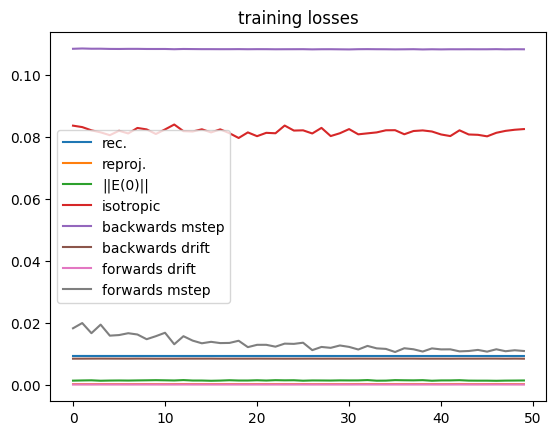

ENCODER


### Layer 0 ###
Not residual
g init is <function xavier_uniform_ at 0x7f51e1c1f600>
g bias init is nn.init.zeros


### Layer 1 ###
Not residual
g init is <function xavier_uniform_ at 0x7f51e1c1f600>
g bias init is nn.init.zeros


DECODER


### Layer 0 ###
Not residual
g init is <function xavier_uniform_ at 0x7f51e1c1f600>
g bias init is nn.init.zeros


### Layer 1 ###
Not residual
g init is <function xavier_uniform_ at 0x7f51e1c1f600>
g bias init is nn.init.zeros


LATENT DRIFT


### Layer 0 ###
Not residual
g init is <function xavier_uniform_ at 0x7f51e1c1f600>
g bias init is <function uniform_ at 0x7f51e1c1efc0>


### Layer 1 ###
Not residual
g init is <function xavier_uniform_ at 0x7f51e1c1f600>
g bias init is <function uniform_ at 0x7f51e1c1efc0>


LATENT CONTROL


### Layer 0 ###
Not residual
g init is <function xavier_uniform_ at 0x7f51e1c1f600>
g bias init is <function zeros_ at 0x7f51e1c1f380>


### Layer 1 ###
Not residual
g init is <function xavier_uniform_ at 0x7f5

  1%|          | 1/100 [00:15<25:11, 15.27s/it]

ep 0: train 0.4290715754032135    test 2.0842292308807373
rec 0.4045586585998535    mstep 0.024512657895684242    jac 0.0
horizon is now 2


  2%|▏         | 2/100 [00:29<23:45, 14.55s/it]

4.661378
it: 2; avg reward: 1424.015452227782; completion rate: 0.52; gamma_max: 4.661377906799316
horizon is now 3


  3%|▎         | 3/100 [00:51<29:00, 17.94s/it]

horizon is now 4


  4%|▍         | 4/100 [01:11<29:53, 18.68s/it]

6.8202343
it: 4; avg reward: 1451.347872218523; completion rate: 0.79; gamma_max: 6.820234298706055
horizon is now 5


  5%|▌         | 5/100 [01:40<35:50, 22.64s/it]

horizon is now 6


  6%|▌         | 6/100 [02:06<37:05, 23.68s/it]

7.554479
it: 6; avg reward: 1812.3904631947873; completion rate: 0.74; gamma_max: 7.554479122161865
horizon is now 7


  7%|▋         | 7/100 [02:41<42:27, 27.39s/it]

horizon is now 8


  8%|▊         | 8/100 [03:12<43:57, 28.67s/it]

6.9961452
it: 8; avg reward: 2215.165492849168; completion rate: 0.88; gamma_max: 6.996145248413086
horizon is now 9


  9%|▉         | 9/100 [03:54<49:41, 32.76s/it]

horizon is now 10


 10%|█         | 10/100 [04:31<51:04, 34.04s/it]

6.7921786
it: 10; avg reward: 2284.812714132445; completion rate: 0.85; gamma_max: 6.792178630828857
horizon is now 11


 11%|█         | 11/100 [05:18<56:26, 38.06s/it]

horizon is now 12


 12%|█▏        | 12/100 [06:01<57:55, 39.50s/it]

6.264487
it: 12; avg reward: 1769.2795010983843; completion rate: 0.89; gamma_max: 6.264486789703369
horizon is now 13


 13%|█▎        | 13/100 [06:54<1:03:14, 43.61s/it]

horizon is now 14


 14%|█▍        | 14/100 [07:42<1:04:27, 44.98s/it]

5.9996014
it: 14; avg reward: 1671.5251964355352; completion rate: 0.9; gamma_max: 5.999601364135742
horizon is now 15


 16%|█▌        | 16/100 [09:32<1:09:31, 49.66s/it]

5.9661975
it: 16; avg reward: 2522.677427686321; completion rate: 0.9; gamma_max: 5.966197490692139


 18%|█▊        | 18/100 [11:21<1:10:50, 51.84s/it]

5.502859
it: 18; avg reward: 2303.984919127964; completion rate: 0.94; gamma_max: 5.502859115600586


 20%|██        | 20/100 [13:11<1:10:39, 53.00s/it]

5.4314756
it: 20; avg reward: 2636.276754775638; completion rate: 0.96; gamma_max: 5.431475639343262


 22%|██▏       | 22/100 [15:00<1:09:36, 53.54s/it]

4.963987
it: 22; avg reward: 2465.259271300518; completion rate: 0.93; gamma_max: 4.963986873626709


 24%|██▍       | 24/100 [16:51<1:08:18, 53.92s/it]

4.3840213
it: 24; avg reward: 2301.1698811253336; completion rate: 0.95; gamma_max: 4.384021282196045


 26%|██▌       | 26/100 [18:40<1:06:37, 54.01s/it]

3.870985
it: 26; avg reward: 2116.6727090959134; completion rate: 0.92; gamma_max: 3.8709850311279297


 28%|██▊       | 28/100 [20:30<1:04:57, 54.14s/it]

3.4517272
it: 28; avg reward: 2463.0451450577243; completion rate: 0.93; gamma_max: 3.4517271518707275


 30%|███       | 30/100 [22:20<1:03:06, 54.09s/it]

3.0857594
it: 30; avg reward: 2133.145867888725; completion rate: 0.96; gamma_max: 3.085759401321411


 32%|███▏      | 32/100 [24:09<1:01:17, 54.08s/it]

2.9572072
it: 32; avg reward: 3044.541939070476; completion rate: 0.97; gamma_max: 2.957207202911377


 34%|███▍      | 34/100 [25:59<59:40, 54.25s/it]  

2.7033892
it: 34; avg reward: 2366.271830474459; completion rate: 0.96; gamma_max: 2.7033891677856445


 36%|███▌      | 36/100 [27:50<57:57, 54.34s/it]  

2.5023828
it: 36; avg reward: 2383.60858683411; completion rate: 0.95; gamma_max: 2.502382755279541


 38%|███▊      | 38/100 [29:40<56:07, 54.31s/it]

2.4819293
it: 38; avg reward: 1887.8574276286788; completion rate: 0.96; gamma_max: 2.481929302215576


 40%|████      | 40/100 [31:30<54:22, 54.37s/it]

2.294764
it: 40; avg reward: 1872.468685526723; completion rate: 0.9; gamma_max: 2.2947640419006348


 42%|████▏     | 42/100 [33:20<52:27, 54.27s/it]

2.4513001
it: 42; avg reward: 2631.0767264132264; completion rate: 0.91; gamma_max: 2.4513001441955566


 44%|████▍     | 44/100 [35:09<50:35, 54.21s/it]

2.240863
it: 44; avg reward: 2555.7625209815183; completion rate: 0.95; gamma_max: 2.240863084793091


 46%|████▌     | 46/100 [37:00<48:55, 54.36s/it]

2.307275
it: 46; avg reward: 2896.0787515007996; completion rate: 0.89; gamma_max: 2.3072750568389893


 48%|████▊     | 48/100 [38:49<46:56, 54.16s/it]

2.0803633
it: 48; avg reward: 2806.8783933838663; completion rate: 0.91; gamma_max: 2.0803632736206055


 50%|█████     | 50/100 [40:39<45:06, 54.13s/it]

2.0341437
it: 50; avg reward: 2051.330707406469; completion rate: 0.95; gamma_max: 2.0341436862945557


 52%|█████▏    | 52/100 [42:28<43:20, 54.19s/it]

2.1449008
it: 52; avg reward: 2498.024603294173; completion rate: 0.93; gamma_max: 2.1449007987976074


 54%|█████▍    | 54/100 [44:19<41:39, 54.33s/it]

1.8840889
it: 54; avg reward: 2050.6001784826026; completion rate: 0.9; gamma_max: 1.8840888738632202


 56%|█████▌    | 56/100 [46:08<39:43, 54.16s/it]

2.023172
it: 56; avg reward: 2716.759429472724; completion rate: 0.9; gamma_max: 2.023171901702881


 58%|█████▊    | 58/100 [47:58<37:51, 54.08s/it]

1.9601632
it: 58; avg reward: 1945.8573780717206; completion rate: 0.92; gamma_max: 1.9601632356643677


 60%|██████    | 60/100 [49:47<36:03, 54.08s/it]

1.9022307
it: 60; avg reward: 2045.7186491031182; completion rate: 0.83; gamma_max: 1.9022307395935059


 62%|██████▏   | 62/100 [51:37<34:17, 54.15s/it]

1.6534147
it: 62; avg reward: 2673.062496536882; completion rate: 0.88; gamma_max: 1.6534147262573242


 64%|██████▍   | 64/100 [53:26<32:27, 54.09s/it]

1.6404305
it: 64; avg reward: 1956.741809953816; completion rate: 0.92; gamma_max: 1.6404304504394531


 66%|██████▌   | 66/100 [55:16<30:40, 54.12s/it]

1.6513197
it: 66; avg reward: 1950.0432274777174; completion rate: 0.84; gamma_max: 1.6513197422027588


 68%|██████▊   | 68/100 [57:05<28:48, 54.00s/it]

1.7783393
it: 68; avg reward: 2085.8606459834696; completion rate: 0.86; gamma_max: 1.7783392667770386


 70%|███████   | 70/100 [58:55<27:05, 54.18s/it]

1.6053354
it: 70; avg reward: 2153.3365604429246; completion rate: 0.88; gamma_max: 1.6053353548049927


 72%|███████▏  | 72/100 [1:00:45<25:14, 54.11s/it]

1.7559338
it: 72; avg reward: 2365.8372387117834; completion rate: 0.86; gamma_max: 1.7559337615966797


 74%|███████▍  | 74/100 [1:02:34<23:25, 54.06s/it]

1.6869483
it: 74; avg reward: 2001.8662772242835; completion rate: 0.82; gamma_max: 1.686948299407959


 76%|███████▌  | 76/100 [1:04:23<21:35, 53.97s/it]

1.8983257
it: 76; avg reward: 2544.7959798920333; completion rate: 0.83; gamma_max: 1.8983256816864014


 78%|███████▊  | 78/100 [1:06:12<19:46, 53.93s/it]

1.7866693
it: 78; avg reward: 1966.4626997595872; completion rate: 0.8; gamma_max: 1.7866692543029785


 80%|████████  | 80/100 [1:08:02<18:02, 54.14s/it]

1.7565721
it: 80; avg reward: 2212.7015695361547; completion rate: 0.85; gamma_max: 1.7565721273422241


 82%|████████▏ | 82/100 [1:09:51<16:12, 54.05s/it]

1.8245951
it: 82; avg reward: 1953.6731889753364; completion rate: 0.86; gamma_max: 1.8245950937271118


 84%|████████▍ | 84/100 [1:11:40<14:24, 54.01s/it]

1.8252761
it: 84; avg reward: 2153.029881341229; completion rate: 0.89; gamma_max: 1.8252761363983154


 86%|████████▌ | 86/100 [1:13:30<12:36, 54.04s/it]

1.8951181
it: 86; avg reward: 1949.9416459839965; completion rate: 0.8; gamma_max: 1.8951181173324585


 88%|████████▊ | 88/100 [1:15:18<10:46, 53.86s/it]

1.9667318
it: 88; avg reward: 2210.042791408437; completion rate: 0.76; gamma_max: 1.9667317867279053


 90%|█████████ | 90/100 [1:17:07<08:57, 53.77s/it]

1.915463
it: 90; avg reward: 1787.134436889653; completion rate: 0.87; gamma_max: 1.9154629707336426


 92%|█████████▏| 92/100 [1:18:57<07:13, 54.14s/it]

1.7712746
it: 92; avg reward: 1426.1042947639946; completion rate: 0.89; gamma_max: 1.7712745666503906


 94%|█████████▍| 94/100 [1:20:47<05:24, 54.15s/it]

1.7283858
it: 94; avg reward: 1444.1901989407681; completion rate: 0.81; gamma_max: 1.7283858060836792


 96%|█████████▌| 96/100 [1:22:36<03:35, 54.00s/it]

1.9497966
it: 96; avg reward: 1979.399142111404; completion rate: 0.83; gamma_max: 1.9497965574264526


 98%|█████████▊| 98/100 [1:24:25<01:47, 53.99s/it]

1.8550603
it: 98; avg reward: 1946.587024591423; completion rate: 0.9; gamma_max: 1.855060338973999


100%|██████████| 100/100 [1:26:34<00:00, 51.94s/it]

ep 99: train 0.21562276780605316    test 0.2224648892879486
rec 0.09122790396213531    mstep 0.12439476698637009    jac 0.0


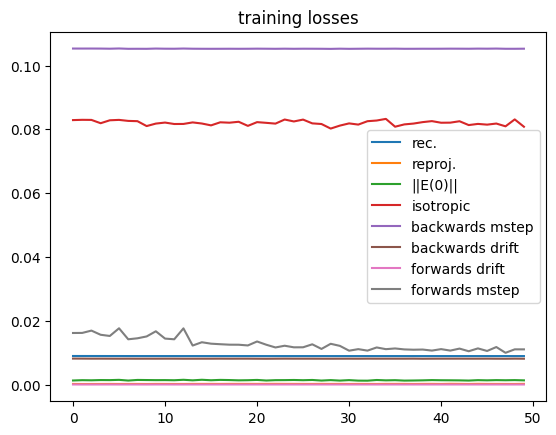

ENCODER


### Layer 0 ###
Not residual
g init is <function xavier_uniform_ at 0x7f51e1c1f600>
g bias init is nn.init.zeros


### Layer 1 ###
Not residual
g init is <function xavier_uniform_ at 0x7f51e1c1f600>
g bias init is nn.init.zeros


DECODER


### Layer 0 ###
Not residual
g init is <function xavier_uniform_ at 0x7f51e1c1f600>
g bias init is nn.init.zeros


### Layer 1 ###
Not residual
g init is <function xavier_uniform_ at 0x7f51e1c1f600>
g bias init is nn.init.zeros


LATENT DRIFT


### Layer 0 ###
Not residual
g init is <function xavier_uniform_ at 0x7f51e1c1f600>
g bias init is <function uniform_ at 0x7f51e1c1efc0>


### Layer 1 ###
Not residual
g init is <function xavier_uniform_ at 0x7f51e1c1f600>
g bias init is <function uniform_ at 0x7f51e1c1efc0>


LATENT CONTROL


### Layer 0 ###
Not residual
g init is <function xavier_uniform_ at 0x7f51e1c1f600>
g bias init is <function zeros_ at 0x7f51e1c1f380>


### Layer 1 ###
Not residual
g init is <function xavier_uniform_ at 0x7f5

  1%|          | 1/100 [00:15<25:01, 15.17s/it]

ep 0: train 0.6832939386367798    test 2.3300719261169434
rec 0.6596859693527222    mstep 0.02360730804502964    jac 0.0
horizon is now 2


  2%|▏         | 2/100 [00:29<23:39, 14.48s/it]

5.1186595
it: 2; avg reward: 2304.4188492204958; completion rate: 0.78; gamma_max: 5.118659496307373
horizon is now 3


  3%|▎         | 3/100 [00:53<30:21, 18.78s/it]

horizon is now 4


  4%|▍         | 4/100 [01:12<30:40, 19.17s/it]

6.8823028
it: 4; avg reward: 2782.807193797758; completion rate: 0.88; gamma_max: 6.882302761077881
horizon is now 5


  5%|▌         | 5/100 [01:43<36:44, 23.21s/it]

horizon is now 6


  6%|▌         | 6/100 [02:08<37:32, 23.97s/it]

6.2792397
it: 6; avg reward: 2440.100952674559; completion rate: 0.96; gamma_max: 6.279239654541016
horizon is now 7


  7%|▋         | 7/100 [02:44<43:25, 28.01s/it]

horizon is now 8


  8%|▊         | 8/100 [03:16<44:32, 29.05s/it]

5.9746914
it: 8; avg reward: 2798.384207407088; completion rate: 0.97; gamma_max: 5.974691390991211
horizon is now 9


  9%|▉         | 9/100 [03:58<50:16, 33.15s/it]

horizon is now 10


 10%|█         | 10/100 [04:35<51:24, 34.28s/it]

4.8679714
it: 10; avg reward: 2772.40909713388; completion rate: 0.97; gamma_max: 4.867971420288086
horizon is now 11


 11%|█         | 11/100 [05:23<57:06, 38.50s/it]

horizon is now 12


 12%|█▏        | 12/100 [06:05<58:15, 39.72s/it]

5.0647855
it: 12; avg reward: 3399.9833298635876; completion rate: 0.98; gamma_max: 5.064785480499268
horizon is now 13


 13%|█▎        | 13/100 [06:59<1:03:41, 43.92s/it]

horizon is now 14


 14%|█▍        | 14/100 [07:47<1:04:43, 45.16s/it]

4.331748
it: 14; avg reward: 2335.133089417456; completion rate: 1.0; gamma_max: 4.331748008728027
horizon is now 15


 16%|█▌        | 16/100 [09:37<1:09:48, 49.86s/it]

3.8360767
it: 16; avg reward: 3187.088116070011; completion rate: 0.97; gamma_max: 3.8360767364501953


 18%|█▊        | 18/100 [11:27<1:11:16, 52.15s/it]

3.8174596
it: 18; avg reward: 2315.608126567404; completion rate: 0.97; gamma_max: 3.8174595832824707


 20%|██        | 20/100 [13:17<1:10:57, 53.21s/it]

3.2388663
it: 20; avg reward: 2320.46515763379; completion rate: 1.0; gamma_max: 3.2388663291931152


 22%|██▏       | 22/100 [15:07<1:09:55, 53.79s/it]

4.0434556
it: 22; avg reward: 2821.5605319136334; completion rate: 0.99; gamma_max: 4.043455600738525


 24%|██▍       | 24/100 [16:58<1:08:35, 54.16s/it]

3.1042433
it: 24; avg reward: 2304.3193927578577; completion rate: 0.99; gamma_max: 3.104243278503418


 26%|██▌       | 26/100 [18:48<1:06:56, 54.28s/it]

3.3634338
it: 26; avg reward: 3152.4222975789485; completion rate: 0.96; gamma_max: 3.363433837890625


 28%|██▊       | 28/100 [20:38<1:05:11, 54.32s/it]

3.3887327
it: 28; avg reward: 2538.2108037228336; completion rate: 1.0; gamma_max: 3.388732671737671


 30%|███       | 30/100 [22:29<1:03:21, 54.31s/it]

3.0431817
it: 30; avg reward: 2060.868749276174; completion rate: 0.99; gamma_max: 3.0431816577911377


 32%|███▏      | 32/100 [24:19<1:01:31, 54.29s/it]

2.8314726
it: 32; avg reward: 2424.9269016857775; completion rate: 0.99; gamma_max: 2.831472635269165


 34%|███▍      | 34/100 [26:05<58:34, 53.25s/it]  

2.9537187
it: 34; avg reward: 2256.675934635835; completion rate: 0.96; gamma_max: 2.953718662261963


 36%|███▌      | 36/100 [27:48<55:28, 52.01s/it]

2.505707
it: 36; avg reward: 1896.0463994484555; completion rate: 1.0; gamma_max: 2.505707025527954


 38%|███▊      | 38/100 [29:32<53:18, 51.58s/it]

3.02457
it: 38; avg reward: 3557.072015946517; completion rate: 0.96; gamma_max: 3.0245699882507324


 40%|████      | 40/100 [31:15<51:11, 51.19s/it]

2.4074986
it: 40; avg reward: 2453.787658731221; completion rate: 0.96; gamma_max: 2.407498598098755


 42%|████▏     | 42/100 [32:58<49:15, 50.96s/it]

2.307437
it: 42; avg reward: 2401.2233644197277; completion rate: 0.92; gamma_max: 2.307436943054199


 44%|████▍     | 44/100 [34:41<47:25, 50.81s/it]

2.246156
it: 44; avg reward: 2577.636346771518; completion rate: 0.96; gamma_max: 2.2461559772491455


 46%|████▌     | 46/100 [36:24<45:53, 50.98s/it]

2.1701975
it: 46; avg reward: 2761.2795783132333; completion rate: 0.96; gamma_max: 2.1701974868774414


 48%|████▊     | 48/100 [38:08<44:14, 51.05s/it]

2.14164
it: 48; avg reward: 1954.6705515849937; completion rate: 0.95; gamma_max: 2.1416399478912354


 50%|█████     | 50/100 [39:52<42:32, 51.04s/it]

2.3864195
it: 50; avg reward: 2280.9015884172545; completion rate: 0.94; gamma_max: 2.3864195346832275


 52%|█████▏    | 52/100 [41:36<40:56, 51.17s/it]

2.0979044
it: 52; avg reward: 2327.7818668013333; completion rate: 0.93; gamma_max: 2.0979044437408447


 54%|█████▍    | 54/100 [43:19<39:07, 51.02s/it]

2.6100907
it: 54; avg reward: 2506.815020201961; completion rate: 0.95; gamma_max: 2.610090732574463


 56%|█████▌    | 56/100 [45:02<37:24, 51.01s/it]

2.310815
it: 56; avg reward: 2259.0114042489818; completion rate: 0.93; gamma_max: 2.3108150959014893


 58%|█████▊    | 58/100 [46:45<35:38, 50.92s/it]

2.6013258
it: 58; avg reward: 2210.723660121354; completion rate: 0.99; gamma_max: 2.601325750350952


 60%|██████    | 60/100 [48:29<34:06, 51.17s/it]

2.9170299
it: 60; avg reward: 2832.9938352636054; completion rate: 0.98; gamma_max: 2.917029857635498


 62%|██████▏   | 62/100 [50:13<32:20, 51.08s/it]

2.7955868
it: 62; avg reward: 3038.1480772535647; completion rate: 0.95; gamma_max: 2.7955868244171143


 64%|██████▍   | 64/100 [51:56<30:36, 51.00s/it]

2.5216947
it: 64; avg reward: 2422.947426046302; completion rate: 0.97; gamma_max: 2.5216946601867676


 66%|██████▌   | 66/100 [53:40<28:53, 50.99s/it]

2.9376748
it: 66; avg reward: 2521.7963953935728; completion rate: 0.92; gamma_max: 2.9376747608184814


 68%|██████▊   | 68/100 [55:23<27:09, 50.93s/it]

2.3975885
it: 68; avg reward: 2152.8922790094534; completion rate: 0.95; gamma_max: 2.3975884914398193


 70%|███████   | 70/100 [57:07<25:32, 51.08s/it]

2.061194
it: 70; avg reward: 1976.2257260343952; completion rate: 0.93; gamma_max: 2.0611939430236816


 72%|███████▏  | 72/100 [58:50<23:46, 50.96s/it]

2.5242257
it: 72; avg reward: 2197.846866233495; completion rate: 0.93; gamma_max: 2.5242257118225098


 74%|███████▍  | 74/100 [1:00:33<22:02, 50.88s/it]

2.7197928
it: 74; avg reward: 2581.148255121623; completion rate: 0.94; gamma_max: 2.7197928428649902


 76%|███████▌  | 76/100 [1:02:16<20:20, 50.87s/it]

2.42301
it: 76; avg reward: 1797.6419277807038; completion rate: 0.9; gamma_max: 2.4230101108551025


 78%|███████▊  | 78/100 [1:04:00<18:43, 51.07s/it]

2.2485986
it: 78; avg reward: 2143.0234588575922; completion rate: 0.9; gamma_max: 2.248598575592041


 80%|████████  | 80/100 [1:05:42<16:57, 50.88s/it]

2.6578968
it: 80; avg reward: 2060.154453078122; completion rate: 0.91; gamma_max: 2.6578967571258545


 82%|████████▏ | 82/100 [1:07:25<15:14, 50.80s/it]

2.609531
it: 82; avg reward: 2340.118822756061; completion rate: 0.98; gamma_max: 2.6095309257507324


 84%|████████▍ | 84/100 [1:09:09<13:33, 50.86s/it]

2.560029
it: 84; avg reward: 3007.724944122748; completion rate: 0.93; gamma_max: 2.5600290298461914


 86%|████████▌ | 86/100 [1:10:52<11:52, 50.87s/it]

2.6584651
it: 86; avg reward: 2740.5980057398433; completion rate: 0.91; gamma_max: 2.6584651470184326


 88%|████████▊ | 88/100 [1:12:34<10:09, 50.77s/it]

2.813659
it: 88; avg reward: 2532.337753957046; completion rate: 0.97; gamma_max: 2.8136589527130127


 90%|█████████ | 90/100 [1:14:18<08:29, 50.99s/it]

2.6143181
it: 90; avg reward: 2440.3120364138654; completion rate: 0.94; gamma_max: 2.6143181324005127


 92%|█████████▏| 92/100 [1:16:01<06:46, 50.85s/it]

2.4723074
it: 92; avg reward: 2483.213650634049; completion rate: 0.96; gamma_max: 2.4723074436187744


 94%|█████████▍| 94/100 [1:17:44<05:05, 50.86s/it]

2.689072
it: 94; avg reward: 2336.111370281163; completion rate: 0.92; gamma_max: 2.6890718936920166


 96%|█████████▌| 96/100 [1:19:27<03:23, 50.80s/it]

2.7143915
it: 96; avg reward: 2127.4589741652007; completion rate: 0.92; gamma_max: 2.7143914699554443


 98%|█████████▊| 98/100 [1:21:10<01:41, 50.78s/it]

2.6406572
it: 98; avg reward: 2501.54361669609; completion rate: 0.96; gamma_max: 2.6406571865081787


100%|██████████| 100/100 [1:23:12<00:00, 49.93s/it]

ep 99: train 0.15108875930309296    test 0.1514119803905487
rec 0.08847107738256454    mstep 0.06261787563562393    jac 0.0


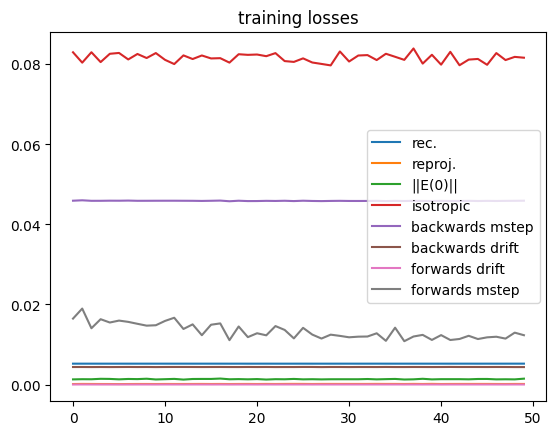

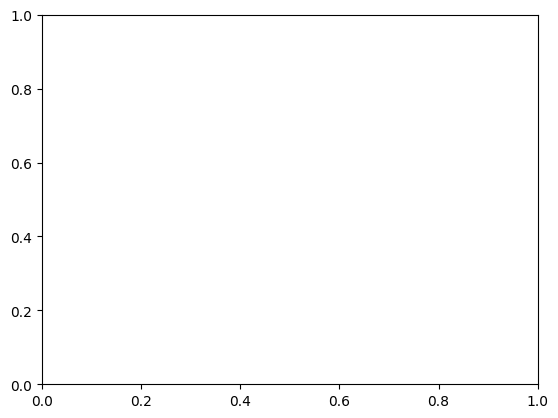

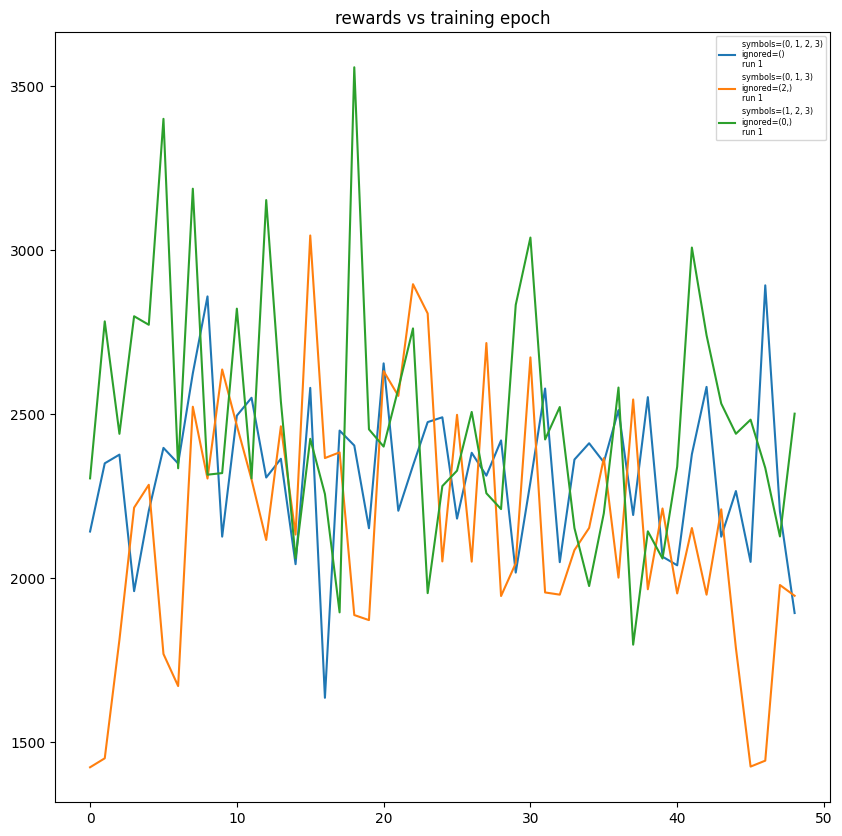

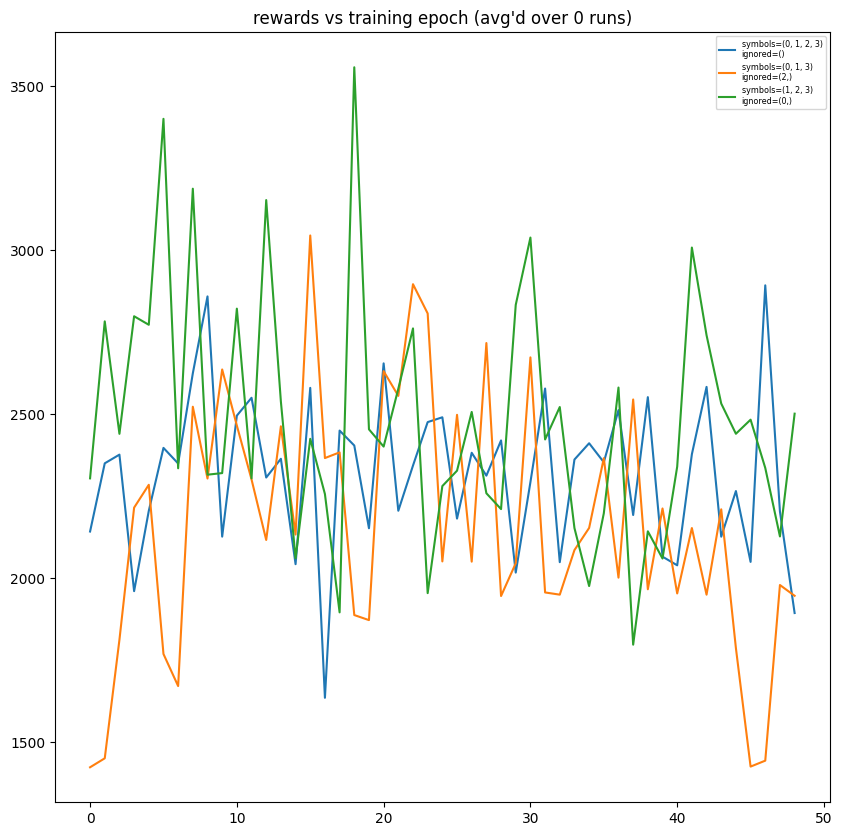

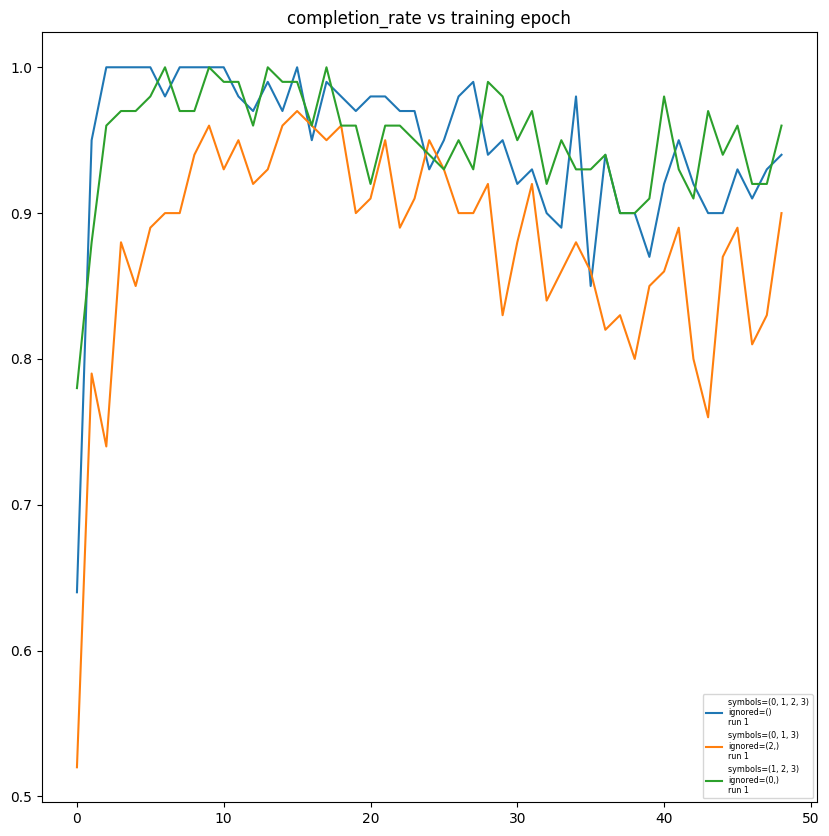

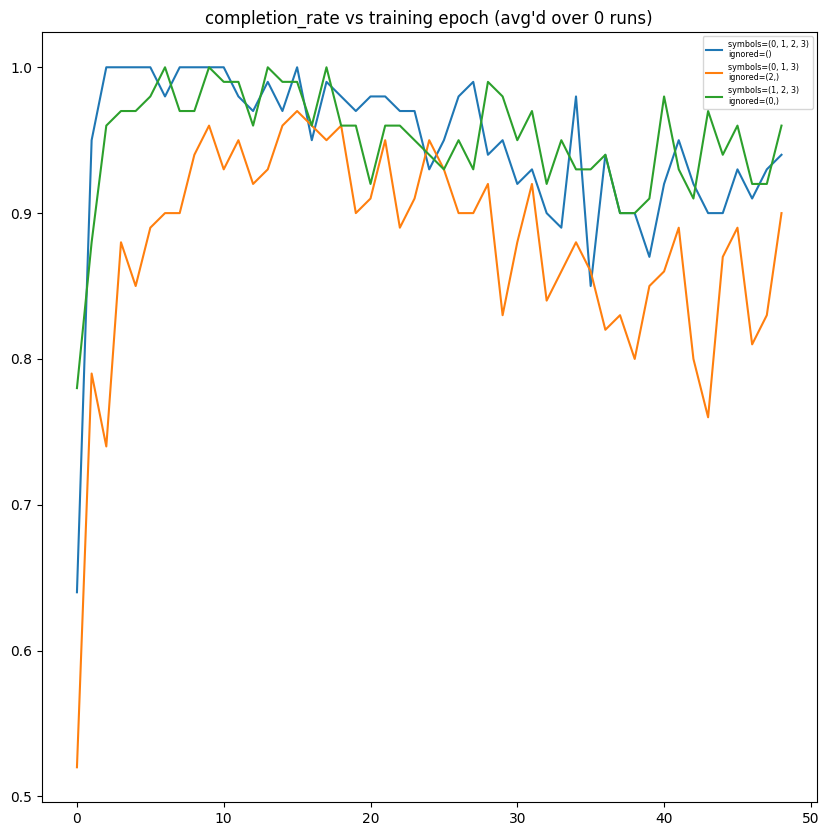

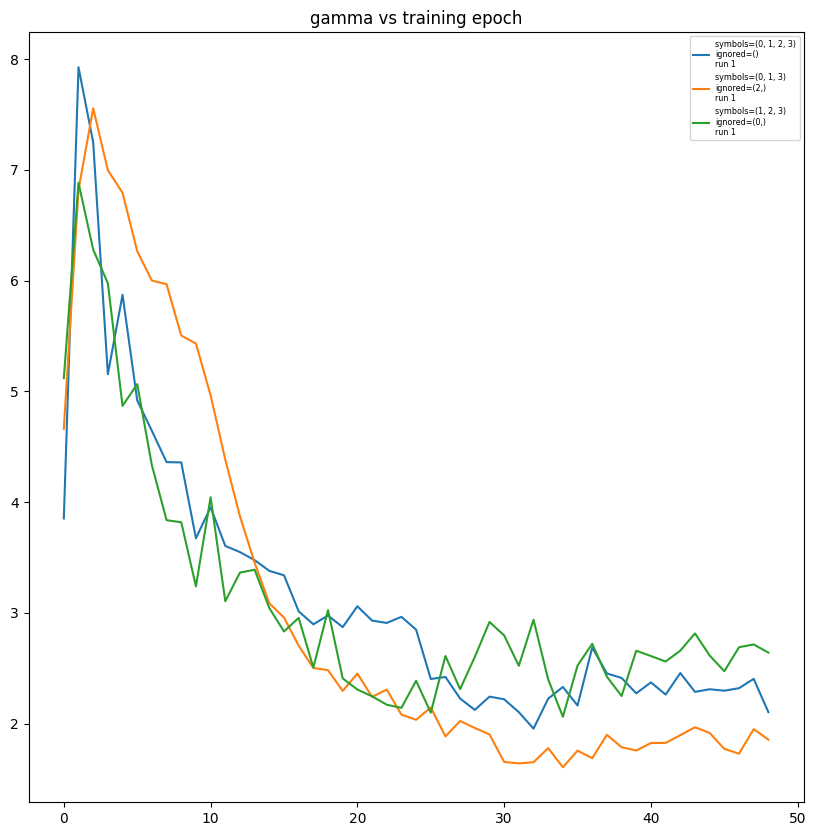

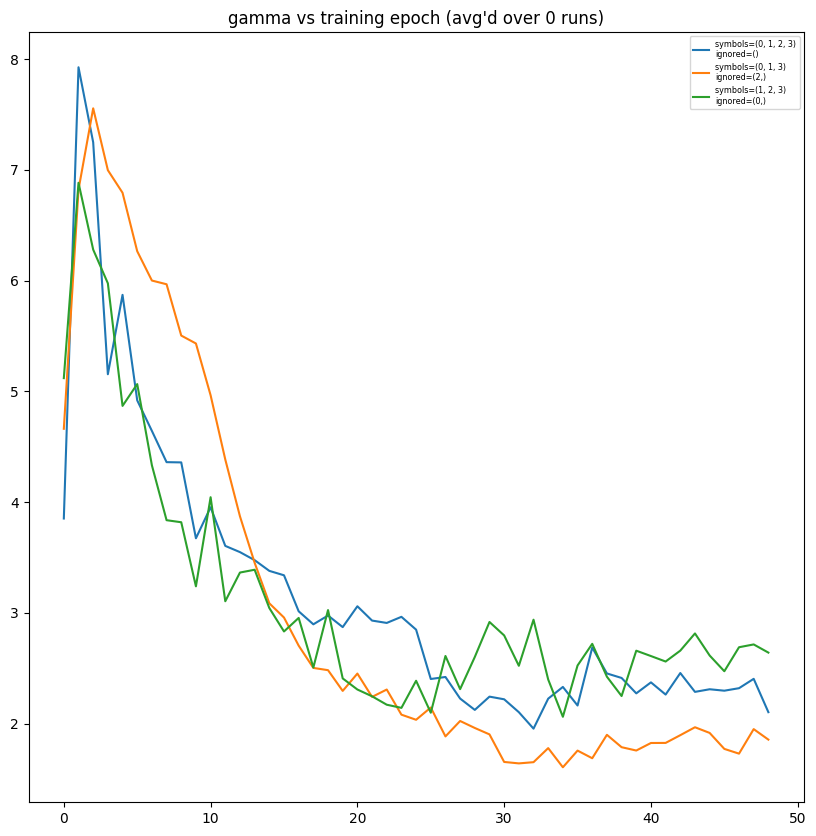

final state
 [(0, 1, 3), (2,)]
saving fwd_penalty_exp_4.pkl
15


In [3]:
from experiments import run_experiment_new
#spec = {'m':[3, 4, 5], 'rec_jac':[True, False, True], 'ptb_eps_x':[1e-9, 1e-6, 1e-3]}

'''
spec = {"predict_mstep" : [True, False, True], 
        "penalize_rec" : [True, True, True], 
        "penalize_reproj" : [False, True, True],
        "penalize_encoder_diagram_mstep" : [False, True, True]}
'''
name = 'fwd_penalty_exp_4'
'''
spec = {'m':[7, 8, 9],
        'm_schedule':[7*[0], 8*[0], 9*[0]]}
'''
spec = {'symbols': [(0,1,2,3), (0, 1, 3), (1, 2, 3), (1, 3)],
        'ignored': [(), (2,), (0,), (0, 2)]}
#n_runs = len(list(spec.items())[0][1])*[1]
n_runs = [1, 1, 1, 0]
print(params.m)
exp=run_experiment_new(data, spec, plot=True, n_runs=n_runs, fname=name, save=True)
print(params.m)


In [4]:
#######################
### Save Experiment ###
#######################

#save_name = 'nontrivial_3'
#save_name = 'nontrivial_4'
#save_name = 'BASELINE'
#save_name = 'reduced_range'
#save_experiment(save_name, exp)

saving reduced_range.pkl


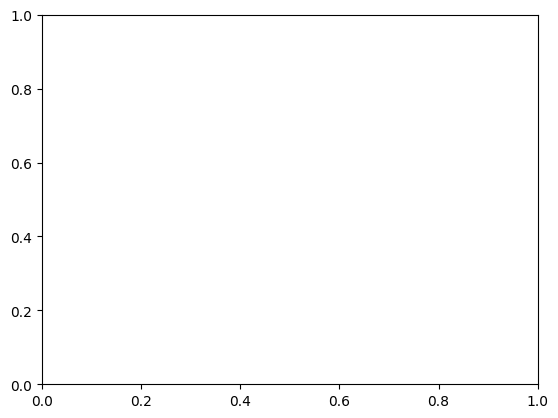

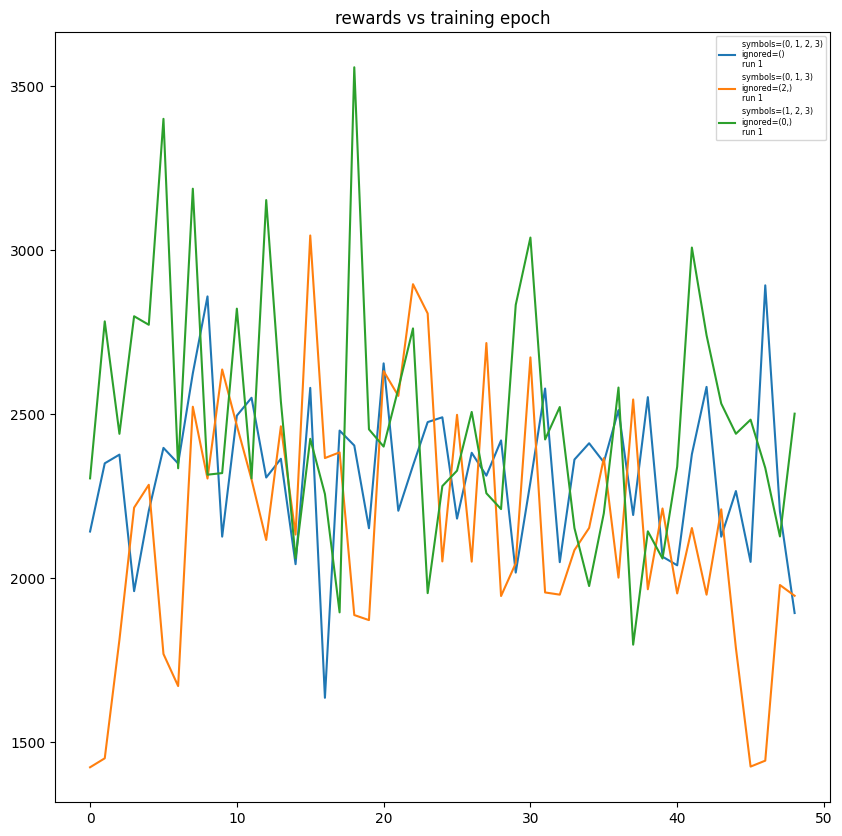

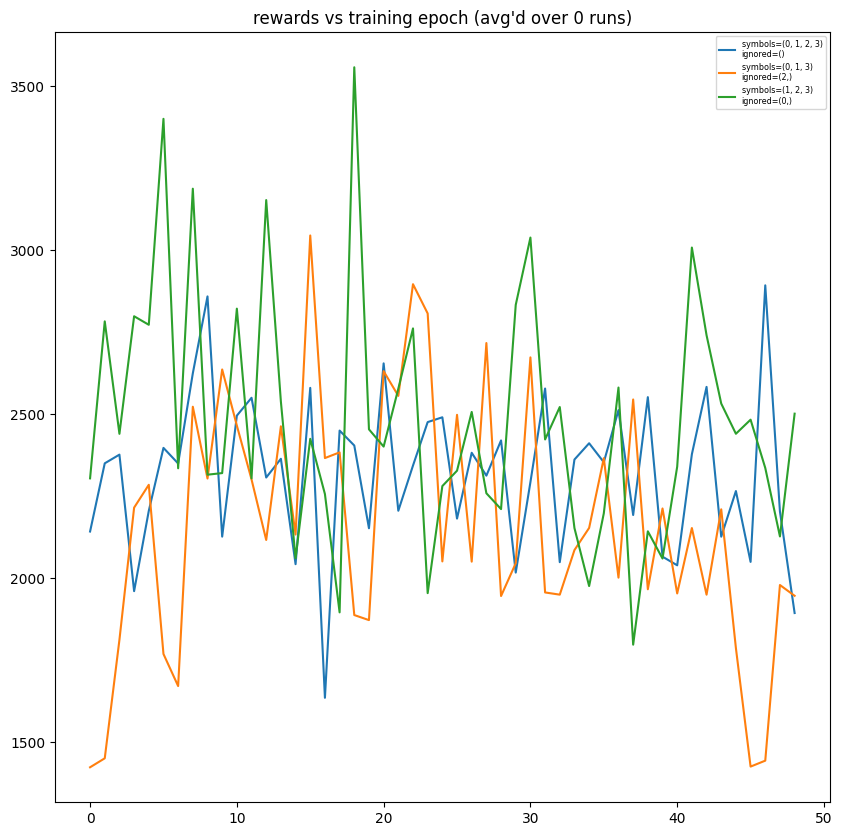

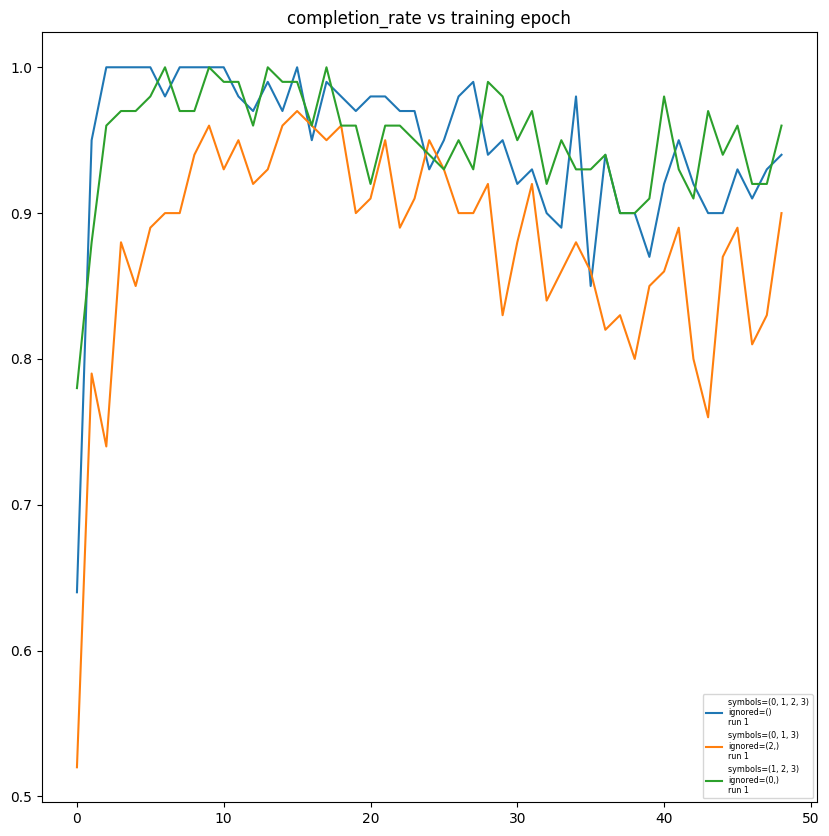

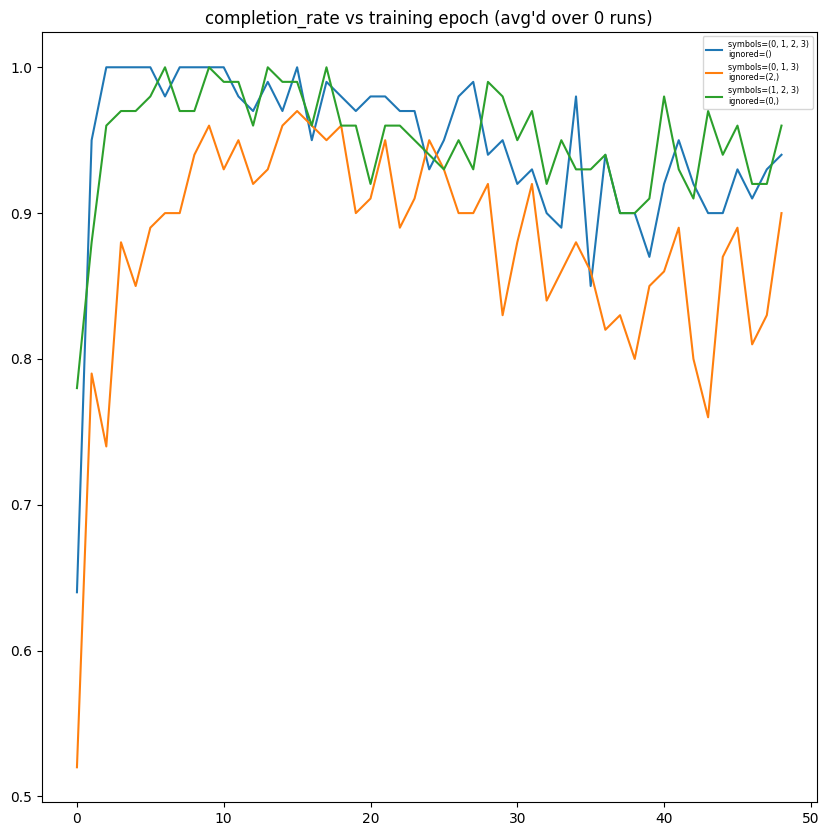

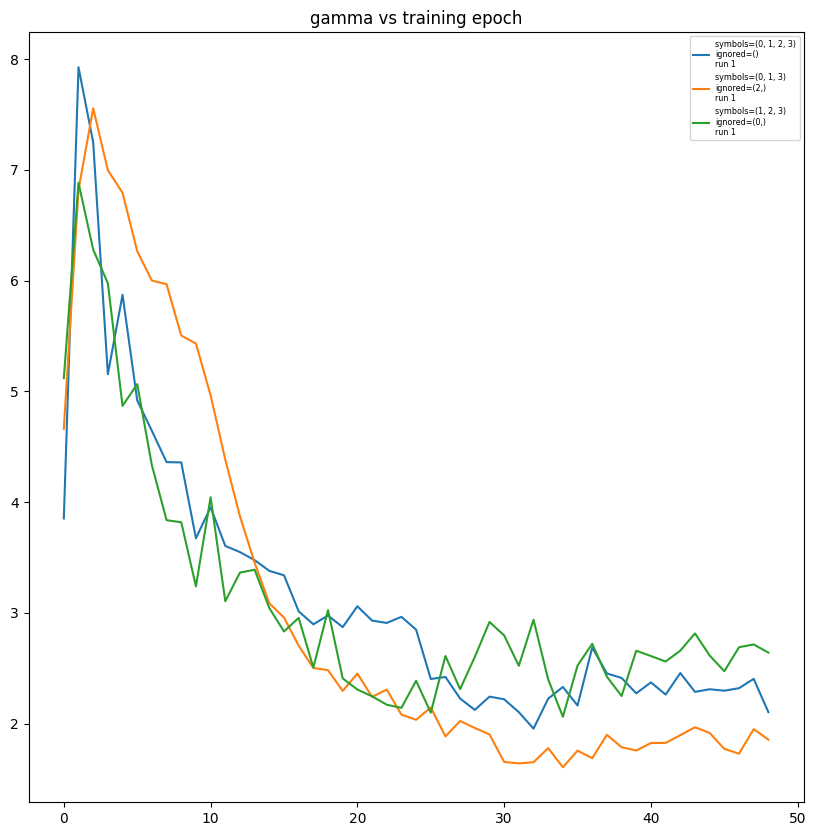

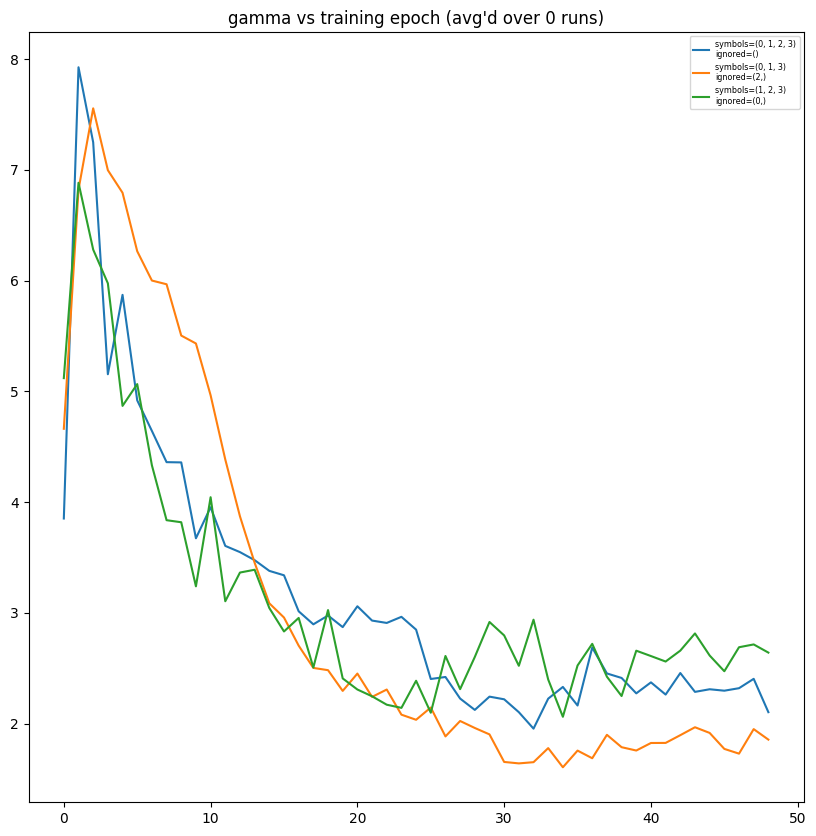

In [3]:
#######################
### Load Experiment ###
#######################

#name = "test_exp"
#name = "backwards-both_runs"
#name = 'both_runs'
#name = "small_pert"
#name = "extra_small_pert"
#name = "xxs_pert_exp"
#name = 'm-ablation'
#name = 'symbol-ablation-default_dataset'
#name = 'symbol-ablation-default_dataset_2'
#name = 'nontrivial_2'
#name = 'fwd_penalty_exp'
#name = 'fwd_penalty_exp_2'
#name = 'nontrivial_3'
#name = 'fwd_penalty_exp_3'
#name = 'BASELINE'
name = 'reduced_range'
exp = load_experiment(name)
plot_experiment_new(exp)

In [5]:
config_idx = 0#2
run_idx = 0#1
#best_model_idx = np.argmax(exp['completion_rate'][config_idx][1][run_idx])
#best_model_idx = np.argmin(exp['gamma'][config_idx][1][run_idx])
#best_model_idx = 79 #-2
best_model_idx = -1
print(best_model_idx)
ae = exp['ae_list'][config_idx][1][run_idx][best_model_idx]
fdyn = exp['fdyn_list'][config_idx][1][run_idx][best_model_idx]
ae.encode(torch.tensor([0.,0.,0.,0.]))

-1


tensor([ 0.0008, -0.0024], device='cuda:0', grad_fn=<ViewBackward0>)

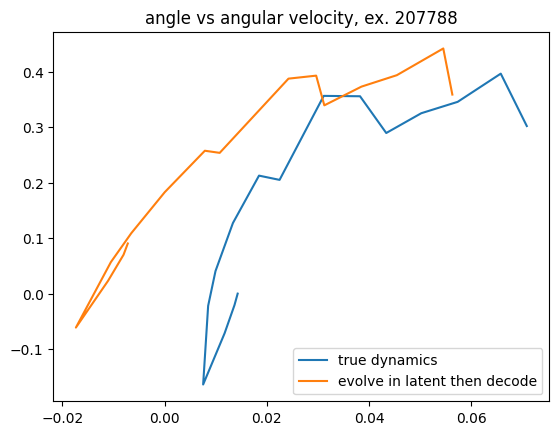

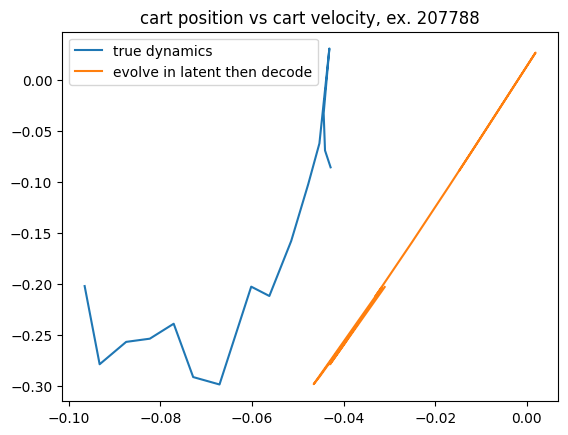

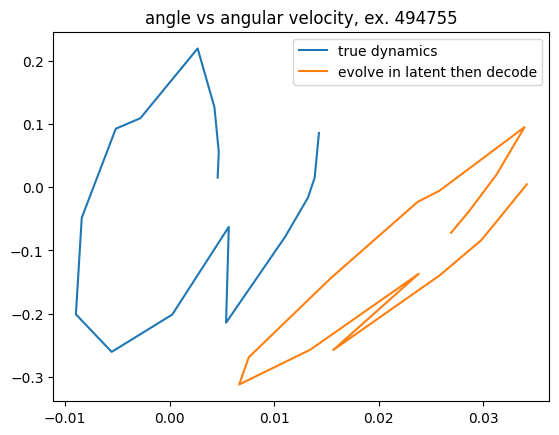

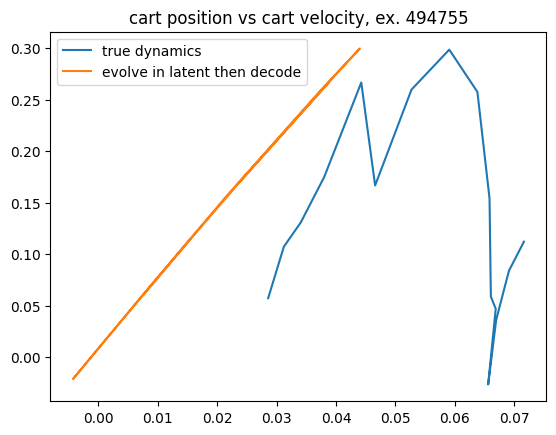

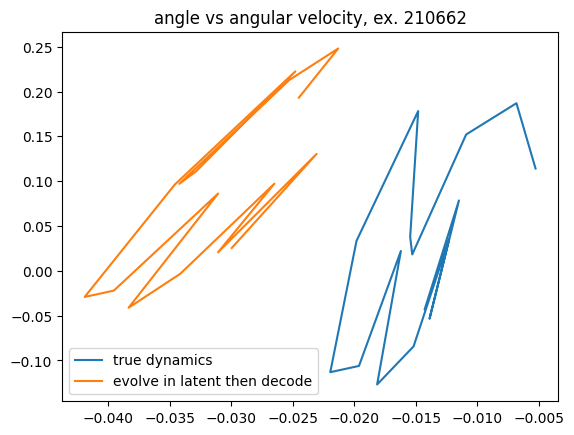

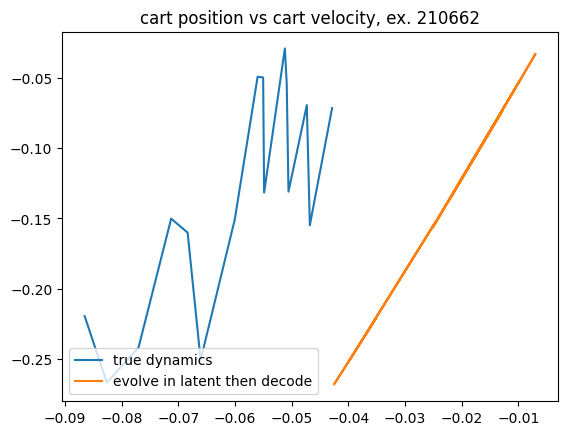

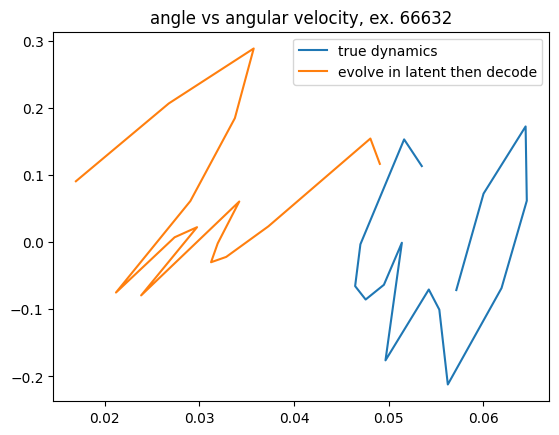

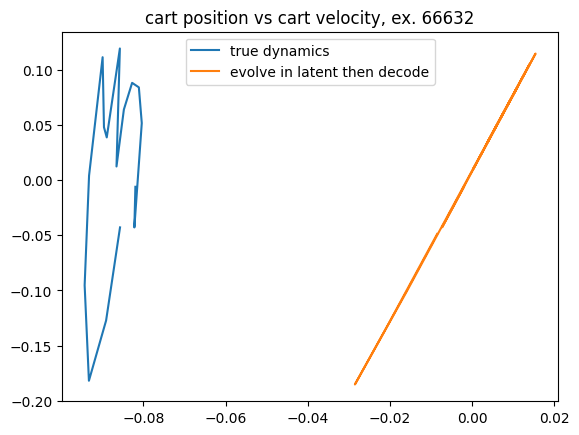

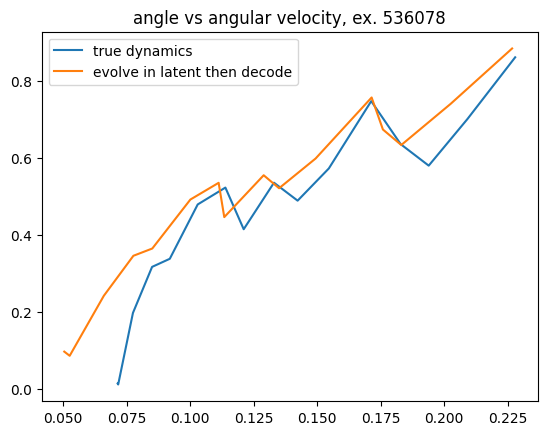

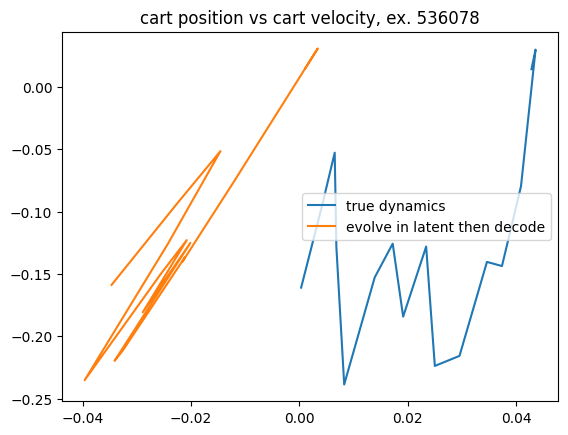

In [6]:
#########################
### Plot Trajectories ###
#########################

plot_trajectories(ae, fdyn, Xtest[0], Utest[0], 5, steps=params.traj_len)#params.m+1)

In [ ]:
######################
### Plot Stability ###
######################

from plotting import plot_stability
n_pts = 5000
eps = np.pi/6 #np.pi/3 
T = 500
tol = np.pi/2
low = [0+-eps, -eps, -eps, -eps]
high = [0+eps, eps, eps, eps]
plot_stability(ae, fdyn, n_pts, low, high, tol, T, visualize=False, latent_traj=True)

In [ ]:
##############################################
### Plot Inverse Image of Latent Norm Ball ###
##############################################

from plotting import plot_preimage_norm_ball

n = 10000
i = 1
j = 2
ivals = [0.]
jvals = [0.]
for ival in ivals:
    for jval in jvals:
        plot_preimage_norm_ball(ae, 0.25, i=i, ival=ival, j=j, jval=jval, n=n) #0.25

In [ ]:
########################
### Stabilize System ###
########################

from controls import LQR
from theorem_tools import verify_invariance

lqr = LQR(ae, fdyn)
_ = stabilize_cartpole(lqr, ae, T=1, tmax=100, stabilize=True, eps=0.25, visualize=False)


z_eq tensor([[ 0.0008, -0.0024]], device='cuda:0', grad_fn=<AddmmBackward0>)


100%|██████████| 500/500 [00:59<00:00,  8.42it/s]


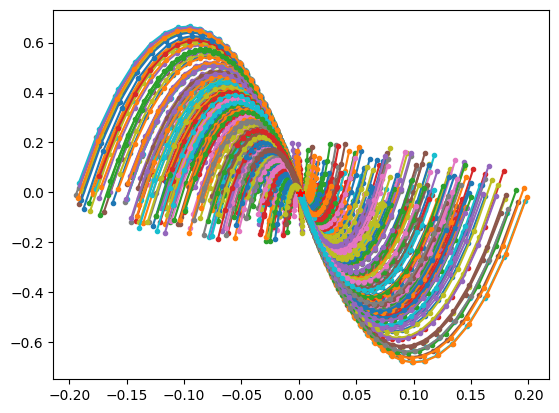

100%|██████████| 500/500 [00:53<00:00,  9.32it/s]


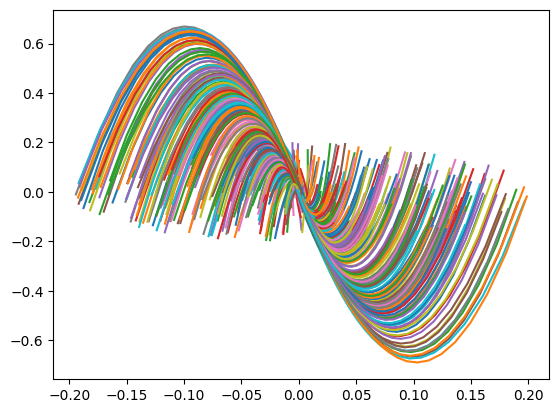

max x: 0.23702630497545157
max v: 0.12288346013626347
max theta: 0.0796734020113945
max w: 0.2619647522544835


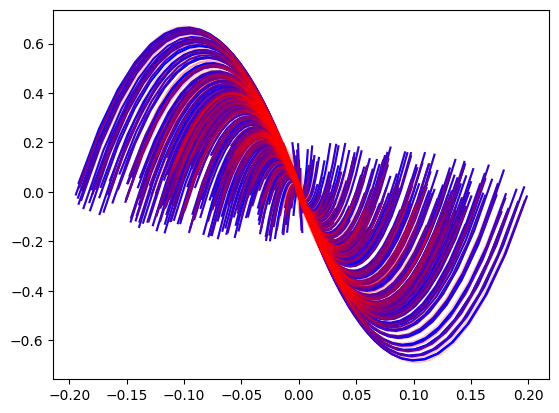

x data (500, 301, 4)
z data (500, 301, 2)
z proj data (500, 301, 2)
u data (500, 300, 1)
gamma forward 0.002154227
gamma backward 0.3045172


In [7]:
####################################
### Initialize Data for Lyapunov ###
####################################

from plotting import plot_latent_trajectories
from utils import rollout_trajectories

r = 1.2e-1#2e-3 #1e-3
r_test = r #1e-3 #5e-3
rz_init = 0.2 # BEST 0.2 0.2 #0.1 #0.02 #0.080 #0.005
#rx_init = rz_init
#rz_proj_init = 0.06
n_traj = 500 #500 #3000 #250 350 1000
T = 300
b = ae.encode(torch.tensor(4*[0.,])).cpu().detach().numpy()


for u_cost in [1]:
    lqr = LQR(ae, fdyn, u_cost=u_cost)
    pts, z_data, x_init_cond = plot_latent_trajectories(ae, fdyn, rz_init, n_traj, T=T, plot_quadratic=False, origin_spec=(b, r), lqr=lqr) #r=0.05
    x_data, z_proj_data, u_data, gammas = rollout_trajectories (ae, fdyn, lqr, x_init_cond, plot=True, n_traj=n_traj, T=T)
    gamma_fwd, gamma_bwd = gammas
    
    for zi in z_data:
        plt.plot(zi[:,0], zi[:,1], 'b-')
    for zi in z_proj_data:
        plt.plot(zi[:,0], zi[:,1], 'r-', alpha=0.2)
    plt.show()
    
    u_data = u_data[...,np.newaxis]
    
    #print(pts.shape)
    print("x data", x_data.shape)
    print("z data", z_data.shape)
    print("z proj data", z_proj_data.shape)
    print("u data", u_data.shape)
    print("gamma forward", gamma_fwd)
    print("gamma backward", gamma_bwd)
    

/home1/lutkus/latent_space/cartpole_lyapunov/theorem_tools.py:367: SyntaxWarning: invalid escape sequence '\c'
  '''
/home1/lutkus/latent_space/cartpole_lyapunov/theorem_tools.py:420: SyntaxWarning: invalid escape sequence '\p'
  ax.plot(Zi[:,0].cpu().detach().numpy(), Zi[:,1].cpu().detach().numpy(), alpha=0.25, label='$f_z(z,\pi(z))$',color='red')
/home1/lutkus/latent_space/cartpole_lyapunov/theorem_tools.py:431: SyntaxWarning: invalid escape sequence '\c'
  plt.title("$(V \circ E)(x(t))$ ", fontsize=16)
/home1/lutkus/.conda/envs/latent-space/lib/python3.13/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


z_eq: tensor([ 0.0008, -0.0024], device='cuda:0', grad_fn=<ViewBackward0>)
pd loss: False
dyn loss: True
lb loss False
grad loss False
rho: 0.85
c lb 0.1
l_dyn 1
l_pd 1
l_lb 1
l_grad 1e-06
using grid data, grid_density: 100
features: 256
coeff: 0.1
LyapunovGeneral(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=256, bias=False)
    (1): Tanh()
    (2): Linear(in_features=256, out_features=256, bias=False)
    (3): Tanh()
    (4): Linear(in_features=256, out_features=1, bias=False)
  )
)
it 0: tensor([0.2365], device='cuda:0', grad_fn=<AddBackward0>)
it 1000: tensor([1.8006e-07], device='cuda:0', grad_fn=<AddBackward0>)
it 2000: tensor([2.2282e-08], device='cuda:0', grad_fn=<AddBackward0>)
it 3000: tensor([9.0134e-09], device='cuda:0', grad_fn=<AddBackward0>)
it 4000: tensor([4.5966e-09], device='cuda:0', grad_fn=<AddBackward0>)
it 5000: tensor([2.2279e-09], device='cuda:0', grad_fn=<AddBackward0>)
it 6000: tensor([9.6458e-10], device='cuda:0', grad_fn=<AddBackward0

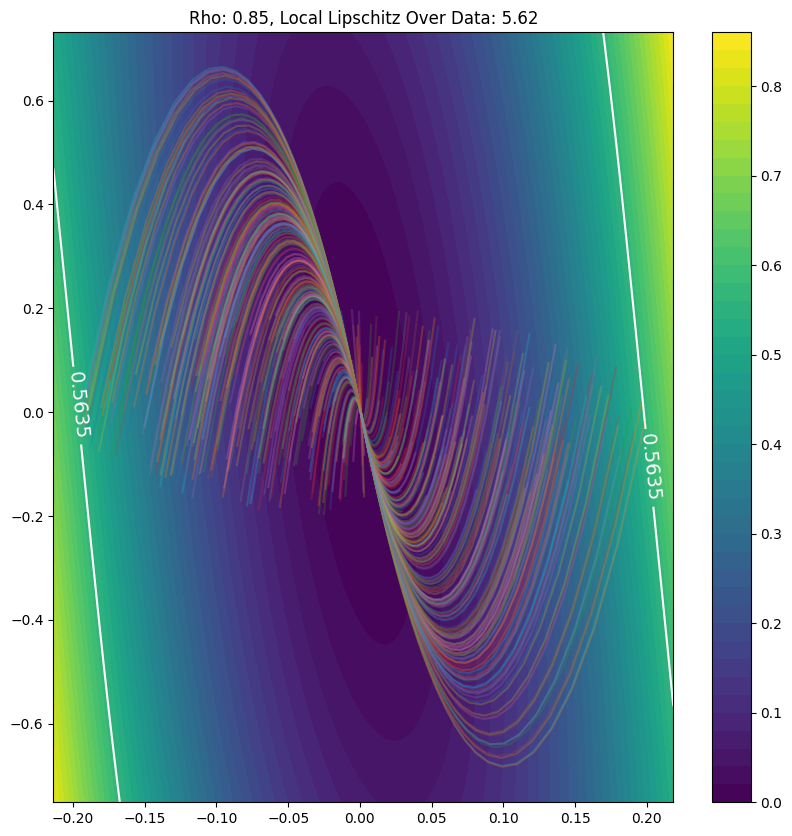

torch.Size([150000])


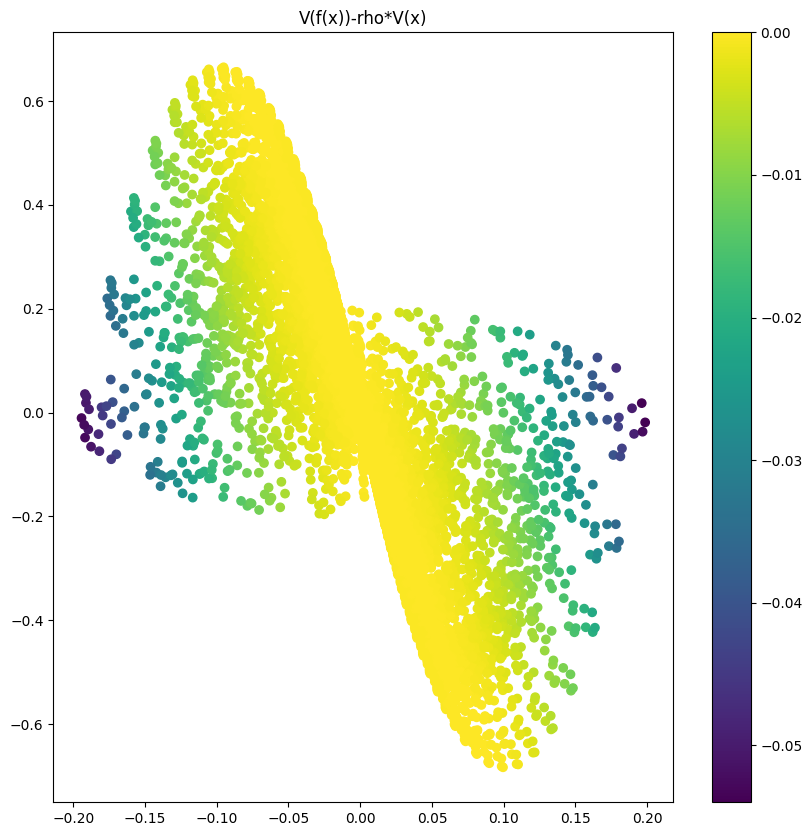

In [8]:
###############################
### Learn Lyapunov Function ###
###############################

from controls import mlp_lyapunov, mlp_lyapunov_reparam
from experiments import load_experiment
from theorem_tools import plot_violation, plot_figure

#z_eq = torch.tensor([0.,0.]).float()
z_eq = ae.encode(torch.tensor([0.,0.,0.,0]).float())
print("z_eq:", z_eq)
rho = 0.85 #0.85 #0.80 #0.75
features = 256
parameterization = "general" #"ellipse"
V, rho, alpha, lip = mlp_lyapunov_reparam(z_data, epochs=int(3e4), lr=2e-4, grid_dens=100, rho=rho, z_eq=z_eq, parameterization=parameterization, features=256) #ep 0.5e4
plot_violation(V, rho, torch.tensor(z_data), ae, lip.item(), gamma_fwd, alpha/6, plot_contours=False)


100%|██████████| 8364/8364 [26:01<00:00,  5.36it/s]


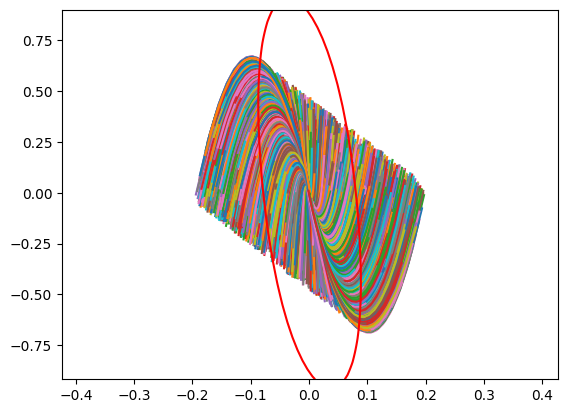

max x: 0.23497779387351914
max v: 0.12452885958327209
max theta: 0.08426938205957413
max w: 0.27366443831762693
(8364, 101, 4)


In [9]:
##############################################
### Compute Skeleton of Invariant Manifold ###
##############################################

from theorem_tools import compute_preimage, plot_lyapunov_lvlsets, verify_invariance

#Dx = compute_preimage(ae, z_data, 0.05, 10, uniform_sampling=True)
#Dx = compute_preimage(ae, z_data, 0.05, 7, uniform_sampling=True) #7

manifold_initial_conditions = compute_preimage(ae, z_data, 0.2, 20, uniform_sampling=True) # x0=0.1, n=7
a0_manifold = torch.max(V(ae.encode(torch.tensor(manifold_initial_conditions)))).cpu().item()

# n_traj doesn't do anything here, only the grid resolution in the previous step influences the number of trajecotries (one per each grid point)
manifold, _, _, _, _, _ = rollout_trajectories(ae, fdyn, lqr, manifold_initial_conditions, n_traj=500, T=100, V=V, a0=a0_manifold/6, n_per_axis=100) 
print(manifold.shape)

In [13]:
############################################################
### Compute Preimage by Sampling from Invariant Manifold ###
############################################################

Dx = compute_preimage(ae, z_data, 0.75, 7, uniform_sampling=True, X=manifold, n_samples=int(1e4), eps=0.01)

100%|██████████| 10000/10000 [00:00<00:00, 412200.40it/s]


In [ ]:
################################################
### Inspect Invariance of Invariant Manifold ###
################################################

print(Dx.shape)
_ = verify_invariance(ae, fdyn, T=150, stabilize=True, X0=Dx[1000:1500], manifold=manifold)

(9964, 4)


 15%|█▌        | 75/500 [02:33<14:34,  2.06s/it]

In [ ]:
##################################################################
### Compute Ly/p and Levelsets over Trajectories from Preimage ###
##################################################################

a0 = torch.max(V(ae.encode(torch.tensor(Dx)))).cpu().item()
print(Dx.shape)
print(a0)
Dz = z_data
Dxtraj, gamma, L, res = plot_lyapunov_lvlsets(V, ae, fdyn, Dx, Dz, a0/6, rho, only_rollout=False, n_per_axis=175) # BEST: a0/6
#plot_lyapunov_lvlsets(V, ae, fdyn, Dx, Dz, a0)

In [ ]:
##################################################################
### Plot Violation of Lyapunov Condition for E(x) Trajectories ###
##################################################################

from theorem_tools import plot_violation, verify_invariance
#verify_invariance(ae, fdyn, T=100, stabilize=True, X0=Dx[:500], manifold=manifold)
plot_violation(V, rho, torch.tensor(Dxtraj), ae, gamma, L, a0/6)

In [ ]:
###################
### Make Figure ###
###################

from plotting import plot_lyapunov_slice
from theorem_tools import plot_figure_final

lqr = LQR(ae, fdyn)
#plot_lyapunov_slice(V, lqr, ae, (0.5, 0.05), (0.5, 0.05), z_data, z_proj_data)
#plot_lyapunov_slice(V, lqr, ae, (rz_init, rz_init), (rz_init, rz_init), z_data, z_proj_data, 1.13, alpha)
plot_figure(V, lqr, ae, (0.2, 0.2), (0.2, 0.2), z_data, z_proj_data, (L*gamma/(1-rho)).item(), a0/6, res, grid_dens=500)
r_plot = 0.05
plot_figure_final(V, ae, None, 2*[r_plot], 2*[r_plot], res, a0/6, (L*gamma/(1-rho)).item(), n_per_axis=500)
#0.001974
